# Exposure to drought


A simple accepted measure for drought is the Standardized Precipitation Index (SPI). Similar to indicators 1.1 and 1.2, this indicator is not a direct measure of health impacts of drought, but rather a measure of the risk factor, which is mediated by a range of complicated causes to health. In general, the claim is that increase in this indicator represents an increased risk, which may lead directly to negative impacts on health or require adaptation measures to mitigate negative impacts.



| SPI  A+S   | SPI Agnew| Category         |
|------------|----------|------------------|
|  >-0.99    | >= -0.84 | Normal           | 
| -1.5 to -1 | < -0.84  | Moderate Drought |
| -1.5 to -2 | < -1.28  | Severe drought   | 
| < -2       | < -1.65  | Extreme drought  |



Select the locations experiencing 'Severe' drought. Define the drought indicator as 'number of months in drought' for a given year.

> NOTE use the -1.5 threshold since it was defined by WMO 2012 document


## Literature on selection of drought index

In 2009, the World Meteorological Organization (WMO) approved the Lincoln Declaration on Drought Indices (LDDI). The LDDI recommends that "the Standardized Precipitation Index (SPI) be used to characterize the meteorological droughts around the world", in addition to other drought indices that were in use in their service. In support of this recommendation, it was suggested that a "comprehensive user manual" describing the SPI should be developed. The manual provides a description of the index, the computation methods, specific examples of where it is currently being used, the strengths and limitations and mapping capabilities.

https://www.ncl.ucar.edu/Applications/spi.shtml

https://climatedataguide.ucar.edu/climate-data/standardized-precipitation-index-spi


Note this one also good for extreme rain

https://link.springer.com/chapter/10.1007/978-94-015-9265-9_2

## SPI drought index

> IMPORTANT: indication from publication (see other doc) that SPI and SPEI diverge due to temperatures. Looking at results the divergance is significant globally! This has implications on both the Lancet results directly and more generally on the use of SPI vs SPEI as an indicator of global prevalence of drought


Python code:

https://www.drought.gov/drought/python-climate-indices


## Data for SPI

Monthly summary data for PPT from ERA interim

Use PPT data from CRU https://crudata.uea.ac.uk/cru/data/hrg/ http://data.ceda.ac.uk//badc/cru/data/cru_ts/cru_ts_4.01/data/ which covers a much longer time period than ECMFW ERA Interim (but only at monthly scale, which is not enough for heatwaves and i think labour).


## Weighting indicator by population and by area

Initial calculation just did a drought count, but this ignores the relative size of the grid squares. A better approach could be to follow https://www.nature.com/articles/s41598-017-14283-2 with 'area in drought' (would need to calculate the real rather than relative size of grid squares).

The question is then how to calculate the population impacted? One possibility is to simply calculate the number of people. This would NOT be directly comparable to the area in drought however. It would only be able to show the relative trends.


In [1]:
%matplotlib inline

In [2]:
from pathlib import Path
from datetime import date

import numba
import rasterio
import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt


from cartopy import crs

from scipy import stats
from tqdm import tnrange, tqdm_notebook

# import population_tools

from config import DATA_SRC, WEATHER_SRC, POP_DATA_SRC


/home/jonathanchambers/Scratch/.conda/envs/science/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [3]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

In [4]:
REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

# For CRU data we only go to 2016 for now. Address this in future versions...
MAX_YEAR = 2017

POPULATION_FILE = POP_DATA_SRC / 'population_count_2000-2020_30min_era_compat.nc'
# POP_FILE = POP_DATA_SRC / 'population_count_2000-2020_eightres.nc'
# COUNTRY_SHAPEFILE = DATA_SRC / 'GIS' / 'world'/ 'ne_50m_admin_0_countries' / 'ne_50m_admin_0_countries.shp'

RESULTS_FOLDER = Path('./results/lancet2019/1.4 drought')
RESULTS_FOLDER.mkdir(parents=True, exist_ok=True)

INTERMEDIATE_RESULTS_FOLDER = DATA_SRC / 'lancet'/ 'drought'/ 'results_2019'
INTERMEDIATE_RESULTS_FOLDER.mkdir(parents=True, exist_ok=True)


EXTREME_DROUGHT_THRESHOLD = -1.5

SPI_INPUT_FILE = DATA_SRC / 'lancet' / 'spi_calculations' / 'spi6_1901_2017_cru.nc'

SPI_PROJ_OUT = DATA_SRC / 'lancet' / 'spi_calculations' / 'spi6_projected'
SPI_PROJ_OUT.mkdir(exist_ok=True)

In [5]:
spi6 = xr.open_dataarray(SPI_INPUT_FILE,
                         chunks={'time': 12}
                        )

In [8]:
spi6.mean(dim=['lon','lat'], skipna=True).plot()
plt.title('Long term trend of SPI6')
plt.savefig(RESULTS_FOLDER / 'spi6_longterm.png', dpi=300)

In [ ]:
spi_sel = spi6.sel(time=slice('2000-01-01',None,None))

## Calculate the number of months where the SPI dropped below the threshold for drought and plot

- Consider the incidences of 'Severe' drought (SPI< -1.5)


In [ ]:
droughts = spi6.where(spi6 < EXTREME_DROUGHT_THRESHOLD)
in_drought = spi6 < EXTREME_DROUGHT_THRESHOLD

In [ ]:

# event_counts = droughts.groupby('time.year').count(dim='time').astype(np.float32).compute()
event_counts = in_drought.groupby('time.year').sum(dim='time').astype(np.float32).compute()

# TODO maybe we can rather 'splice' the SPI calculation by using the historic data from CRU and the current data from ERA?

# Make the coordinates compatible with the population file:
# Convert the drought data from -180 to 180 => 0 to 360
event_counts = event_counts.roll(lon=len(event_counts.lon)//2, roll_coords=False)

# Shift the coord reference to the corner of the cell instead of the centre
event_counts['lon'] = np.arange(0, 360, 0.5)
event_counts['lat'] += 0.25

# Rename the coodinates

event_counts = event_counts.rename({'lat': 'latitude', 'lon': 'longitude'})

In [ ]:
event_counts.to_netcdf(INTERMEDIATE_RESULTS_FOLDER / 'drought_event_counts.nc')

In [9]:
event_counts = xr.open_dataarray(INTERMEDIATE_RESULTS_FOLDER / 'drought_event_counts.nc')

# Export as simple tables for viz

In [10]:
event_counts.name = 'drought_event_counts'

In [ ]:
out_folder = (Path('..') / '2019 material' / 'Data for visualisation' / 'drought_events_map_as_tables').resolve()

In [ ]:
for year in event_counts.year:
    e = event_counts.sel(year=year).to_dataframe().reset_index()
    e.to_csv(out_folder / f'{np.asscalar(year)}_drought_events.csv')

## Map the mean drought counts per year

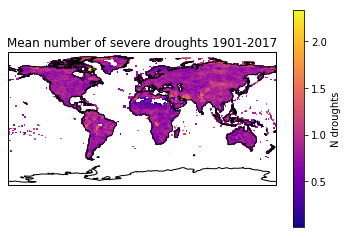

In [18]:
event_counts_mean = event_counts.mean(dim='year')
event_counts_mean = event_counts_mean.where(event_counts_mean > 0)
event_counts_mean.name = 'N droughts'
# drought_counts_mean.plot()

f = plt.figure()
ax = plt.subplot(projection=crs.PlateCarree())
p = event_counts_mean.plot.pcolormesh(
    cmap='plasma',
    transform=crs.PlateCarree()
)
ax.coastlines()
plt.title(f'Mean number of severe droughts 1901-{MAX_YEAR}')

plt.savefig(RESULTS_FOLDER / f'mean n droughts 1901-{MAX_YEAR} map.png', 
            bbox_inches='tight', dpi=300)

## Express global trend as 'area in drought'

In [7]:
# Calculate grid cell areas
delta_lon = spi6.lon[1] - spi6.lon[0]
earth_radius = 6371

areas = (np.sin(np.radians(spi6.lat.values + 0.25))
 - np.sin(np.radians(spi6.lat.values - 0.25))) * (np.radians(delta_lon.values)) * earth_radius**2

In [8]:

drought_area = in_drought.astype(int)

drought_area['areas'] = xr.DataArray(areas, dims=['lat'], coords={'lat': drought_area.lat})
drought_area = drought_area * drought_area.areas

In [9]:
drought_area_ts = in_drought.sum(dim=['lat', 'lon']).compute()
drought_area_ts.name = 'million km2'

/home/jonathanchambers/Scratch/.conda/envs/science/lib/python3.7/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


In [10]:
drought_area_ts.to_dataframe().to_excel(RESULTS_FOLDER / 'area_in_drought_spi6.xlsx')

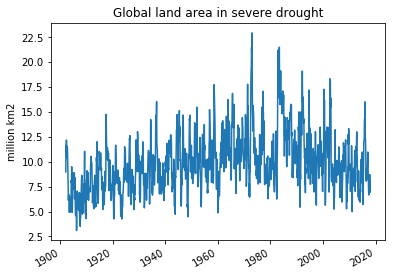

In [11]:
(drought_area_ts[12:] / 1_000_000).plot()
plt.title('Global land area in severe drought')
plt.xlabel('')
plt.savefig(RESULTS_FOLDER / 'area_in_drought_spi6.png', dpi=300)

In [12]:
drought_ref = (in_drought
               .sel(time=slice(f'{REFERENCE_YEAR_START}-01-01', f'{REFERENCE_YEAR_END}-12-31'))
               .groupby('time.month')
               .mean(dim='time'))

In [13]:
in_drought.sel(time=slice(f'{REFERENCE_YEAR_START}-01-01', f'{REFERENCE_YEAR_END}-12-31'))

<xarray.DataArray (lat: 360, lon: 720, time: 240)>
dask.array<shape=(360, 720, 240), dtype=float64, chunksize=(360, 720, 12)>
Coordinates:
  * lon      (lon) float32 -179.75 -179.25 -178.75 ... 178.75 179.25 179.75
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 1986-01-16 1986-02-15 ... 2005-12-16
    areas    (lat) float64 13.49 40.45 67.43 94.39 ... 94.39 67.43 40.45 13.49

## Project the drought counts to the population to get the drought exposure

In [20]:
population = xr.open_dataarray(POPULATION_FILE)

In [21]:
drought_count_projected = event_counts * population

In [18]:
# Old method with old population file
# drought_count_projected = population_tools.project_to_population(event_counts, 
#                                                                  end_year=2016, 
#                                                                  norm=False, get_ts=False)

In [22]:
event_count_projected_ts = drought_count_projected.sum(dim=['latitude', 'longitude']).compute()

In [26]:
event_count_projected_ts = event_count_projected_ts.to_dataframe('drought exposures')

event_count_projected_ts.to_excel(RESULTS_FOLDER / 'drought exposures.xlsx')

In [27]:
event_count_projected_ts = pd.read_excel(RESULTS_FOLDER / 'drought exposures.xlsx').set_index('year')

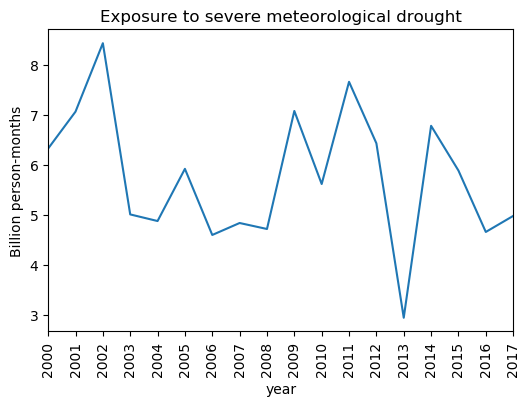

In [28]:
(event_count_projected_ts['drought exposures'] / 1_000_000_000).plot()
plt.xticks(event_count_projected_ts.index, rotation=90)
plt.ylabel('Billion person-months')
plt.title('Exposure to severe meteorological drought')
plt.savefig(RESULTS_FOLDER / 'drought exposure.png', dpi=300)
plt.savefig(RESULTS_FOLDER / 'drought exposure.pdf')

In [29]:
event_count_projected_ts.mean() / 1_000_000_000

drought exposures    5.7698
dtype: float64

# Calculate the change in N events relative to baseline

In [11]:
event_counts_ref = event_counts.sel(year=slice(REFERENCE_YEAR_START, REFERENCE_YEAR_END)).mean(dim='year')

In [12]:
event_change = event_counts.sel(year=slice(2000, None)) - event_counts_ref

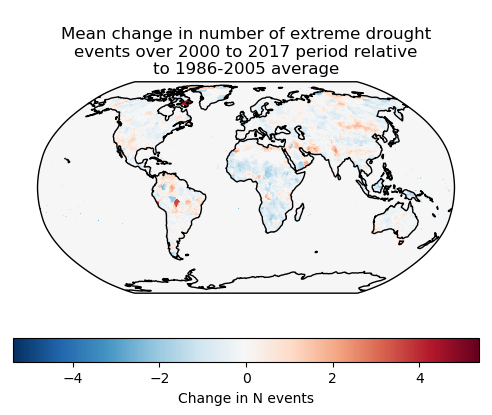

In [23]:
data = event_change.mean(dim='year')

f = plt.figure( constrained_layout=False)
ax = plt.subplot(projection=crs.Robinson())
p = data.plot.pcolormesh(
    transform=crs.PlateCarree(),
    cbar_kwargs={'orientation':'horizontal','label':''}
)
p.colorbar.set_label('Change in N events')

ax.coastlines()

ax.set_title(f'''
Mean change in number of extreme drought
events over 2000 to {MAX_YEAR} period relative
to {REFERENCE_YEAR_START}-{REFERENCE_YEAR_END} average''')

f.savefig(RESULTS_FOLDER / f'mean events change 2000-{MAX_YEAR} map.png', 
            bbox_inches='tight', dpi=600)
plt.savefig(RESULTS_FOLDER / f'mean events change 2000-{MAX_YEAR} map.pdf', 
            bbox_inches='tight')

In [27]:
event_change_ts = event_change.sum(dim=['latitude', 'longitude']).compute()

In [28]:
drought_change_projected  = (event_change * population).sum(dim=['latitude', 'longitude']).compute()

In [29]:
# drought_change_projected = population_tools.project_to_population(event_change, 
#                                                                  end_year=2016, 
#                                                                  norm=False, get_ts=True).compute()

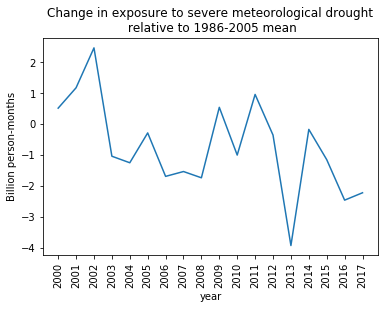

In [35]:
(drought_change_projected / 1_000_000_000).plot()
plt.xticks(drought_change_projected.year, rotation=90)

plt.ylabel('Billion person-months')
plt.title(f'Change in exposure to severe meteorological drought\n relative to {REFERENCE_YEAR_START}-{REFERENCE_YEAR_END} mean')
plt.savefig(RESULTS_FOLDER / 'drought exposure change.png', dpi=300)

## Map the latest year

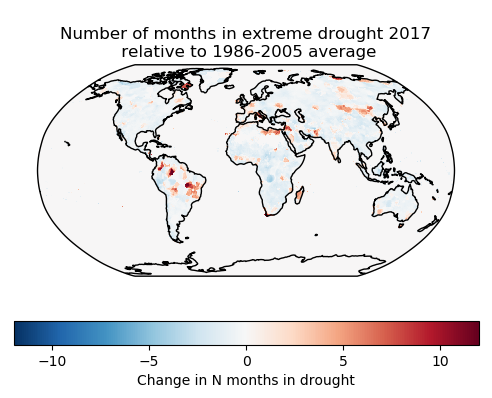

In [24]:
data = event_counts.sel(year=MAX_YEAR) - event_counts_ref

f, ax = plt.subplots(constrained_layout=False, subplot_kw=dict(projection=crs.Robinson()))
               
p = data.plot.pcolormesh(
    transform=crs.PlateCarree(),
    cbar_kwargs={'orientation':'horizontal','label':''}
)
p.colorbar.set_label('Change in N months in drought')

ax.coastlines()

plt.title(f'''
Number of months in extreme drought {MAX_YEAR}
 relative to {REFERENCE_YEAR_START}-{REFERENCE_YEAR_END} average''')

f.savefig(RESULTS_FOLDER / f'events change {MAX_YEAR} map.png', 
            bbox_inches='tight', dpi=600)


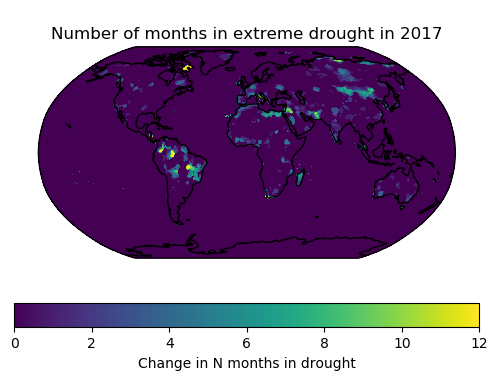

In [13]:
data = event_counts.sel(year=MAX_YEAR)

f, ax = plt.subplots(constrained_layout=False, subplot_kw=dict(projection=crs.Robinson()))
               
p = data.plot.pcolormesh(
    transform=crs.PlateCarree(),
    cbar_kwargs={'orientation':'horizontal','label':''}
)
p.colorbar.set_label('Change in N months in drought')

ax.coastlines()

plt.title(f'''
Number of months in extreme drought in {MAX_YEAR}''')

f.savefig(RESULTS_FOLDER / f'events abs {MAX_YEAR} map.png', 
            bbox_inches='tight', dpi=600)


In [21]:
(RESULTS_FOLDER / f'events change {MAX_YEAR} map.png')

PosixPath('results/lancet2019/global/1.4 drought/events change 2017 map.png')

# Experiment - see what the trend in absolute SPI is - idea that if it overall increases, that means we are getting 'more extreme'. Note that should also somehow factor out any mean trend - i.e. if the mean of SPI (not abs) across everywhere is trending then that could affec the abs SPI as well

# Second aspect - also need to mask to consider only land

## Results

OK that's wierd - see a sharp trend up until 1960s then a leveling off and even more a downward trend... Actually something seems just wrong to me, pattern doesn't make sense. Also not consistent with all the other research that shows that we are seeing more extreme wet/dry events. 

/home/jonathanchambers/Scratch/.conda/envs/science/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


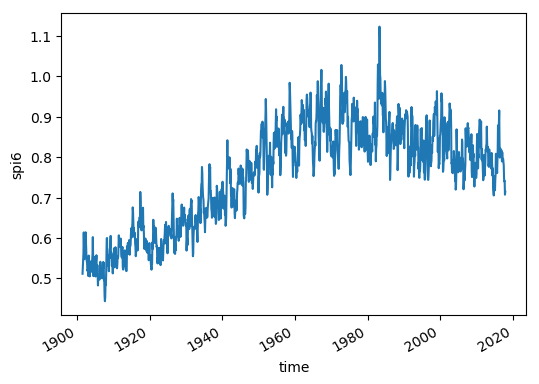

In [35]:
np.abs(spi6).mean(dim=['lon','lat'], skipna=True).plot()
# plt.title('Long term trend of SPI6')
# plt.savefig(RESULTS_FOLDER / 'spi6_longterm.png', dpi=300)